# 복잡한 함수의 미분
+ 만든 dezero 패키지가 어떤 함수가 들어와도 잘 작동 되는지 확인
+ add, mul, neg, sub, div, pow로 이루어진 함수는 모두 작동해야함 -> 이 함수들에 대하여 forward, backward가 되어있으므로
+ 즉 위 계산방식말고 (Ex log?)계산은 안될거라고 보임 -> 해당 계산 방법을 모르니까
+ 나머지 복잡한 함수에 대하여 잘 되는지 (해당 함수는 테스트용 함수로 주로 최적화 문제에 사용되는 벤치마크용 함수)

In [1]:
# sphere 함수
# z = x^2 + y^2

import numpy as np
from dezero import Variable

def sphere(x, y):
    z = x ** 2 + y ** 2
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(2.0))
z = sphere(x, y)
z.backward()

print(z.data)
print(x.grad, y.grad)

5.0
2.0 4.0


In [2]:
# matyas 함수
# z = 0.26 * (x^2 + y^2) - 0.48xy

def matyas(x, y):
    z = 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(2.0))
z = matyas(x, y)
z.backward()

print(z.data)
print(x.grad, y.grad)

0.3400000000000001
-0.43999999999999995 0.56


In [3]:
# goldstein_price 함수
# z = [1 + (x + y + 1)^2 * (19 - 14x + 3x^2 - 14y + 6xy + 3y^2)] * [30 + (2x - 3y)^2 * (18 - 32x + 12x^2 + 48y - 36xy + 27y^2)]

def goldstein_price(x, y):
    z = (1 + (x + y + 1) ** 2 * (19 - 14 * x + 3 * x ** 2 - 14 * y + 6 * x * y + 3 * y ** 2)) * (30 + (2 * x - 3 * y) ** 2 * (18 - 32 * x + 12 * x ** 2 + 48 * y - 36 * x * y + 27 * y ** 2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(2.0))
z = goldstein_price(x, y)
z.backward()

print(z.data)
print(x.grad, y.grad)

137150.0
-15840.0 530160.0


In [4]:
# log2 함수 -> log 계산 방법이 variable에 없으므로 오류 발생하는게 정상

def log2(x):
    return np.log2(x)

x = Variable(np.array(2.0))
y = log2(x)
y.backward()

print(y.data)
print(x.grad)

TypeError: loop of ufunc does not support argument 0 of type Variable which has no callable log2 method

# 계산 그래프 시각화
+ 복잡한 식을 직접 확인하기 위해

dot sample 파일 생성

```dot
digraph g{
    x
    y
}
```

[sample.dot]('./sample.dot')파일 생성 후

dot sample.dot -T png -o sample.png

명령어 실행

![sample.png](./sample.png)

```dot
digraph g{
    1 [label="x", color=orange, style=filled]
    2 [label="y", color=blue, style=filled]
}
```
![sample.png](./sample_1.png)

```dot
digraph g{
    1 [label="x", color=orange, style=filled]
    2 [label="y", color=orange, style=filled]
    3 [label="Exp", color=lightblue, style=filled, shape=box]
    1 -> 3
    3 -> 2
}
```
![sample.png](./sample_2.png)

# python 코드로 계산 그래프 시각화

In [ ]:
from dezero.utils import get_dot_graph

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(2.0))
y = x0 + x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

txt = get_dot_graph(y, verbose=False)
print(txt)

with open('sample_3.dot', 'w') as f:
    f.write(txt)
    
# dot 파일을 png 파일로 변경하는 명령어
!dot -T png sample_3.dot -o sample_3.png

digraph g {
	4472019216 [label="y", color=orange, style=filled]
	4472020176 [label="Add", color=lightblue, style=filled, shape=box]
	4472020304 -> 4472020176
	4472021200 -> 4472020176
	4472020176 -> 4472019216
	4472020304 [label="x0", color=orange, style=filled]
	4472021200 [label="x1", color=orange, style=filled]
}


![sample.png](./sample_3.png)

dot 파일이 들여쓰기(tap)도 지원하므로 코드 가독성을 위해 \t tap추가하여 파일 변경
```python
def _dot_var(v, verbose=False):
    dot_var = '\t{} [label="{}", color=orange, style=filled]\n'
    ...

def _dot_func(f):
    # for function
    dot_func = '\t{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    ...

    # for edge
    dot_edge = '\t{} -> {}\n'
    ...
```

get_dot_graph 함수는 generation이 필요없다 -> 세대 상관 없이 노드끼리 연결하면 되기 때문

return 값은 dot언어로 리턴

```python
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key=lambda x: x.generation)
            seen_set.add(f)

    add_func(output.creator)
    txt += _dot_var(output, verbose)

    while funcs:
        func = funcs.pop()
        txt += _dot_func(func)
        for x in func.inputs:
            txt += _dot_var(x, verbose)

            if x.creator is not None:
                add_func(x.creator)

    return 'digraph g {\n' + txt + '}'
```

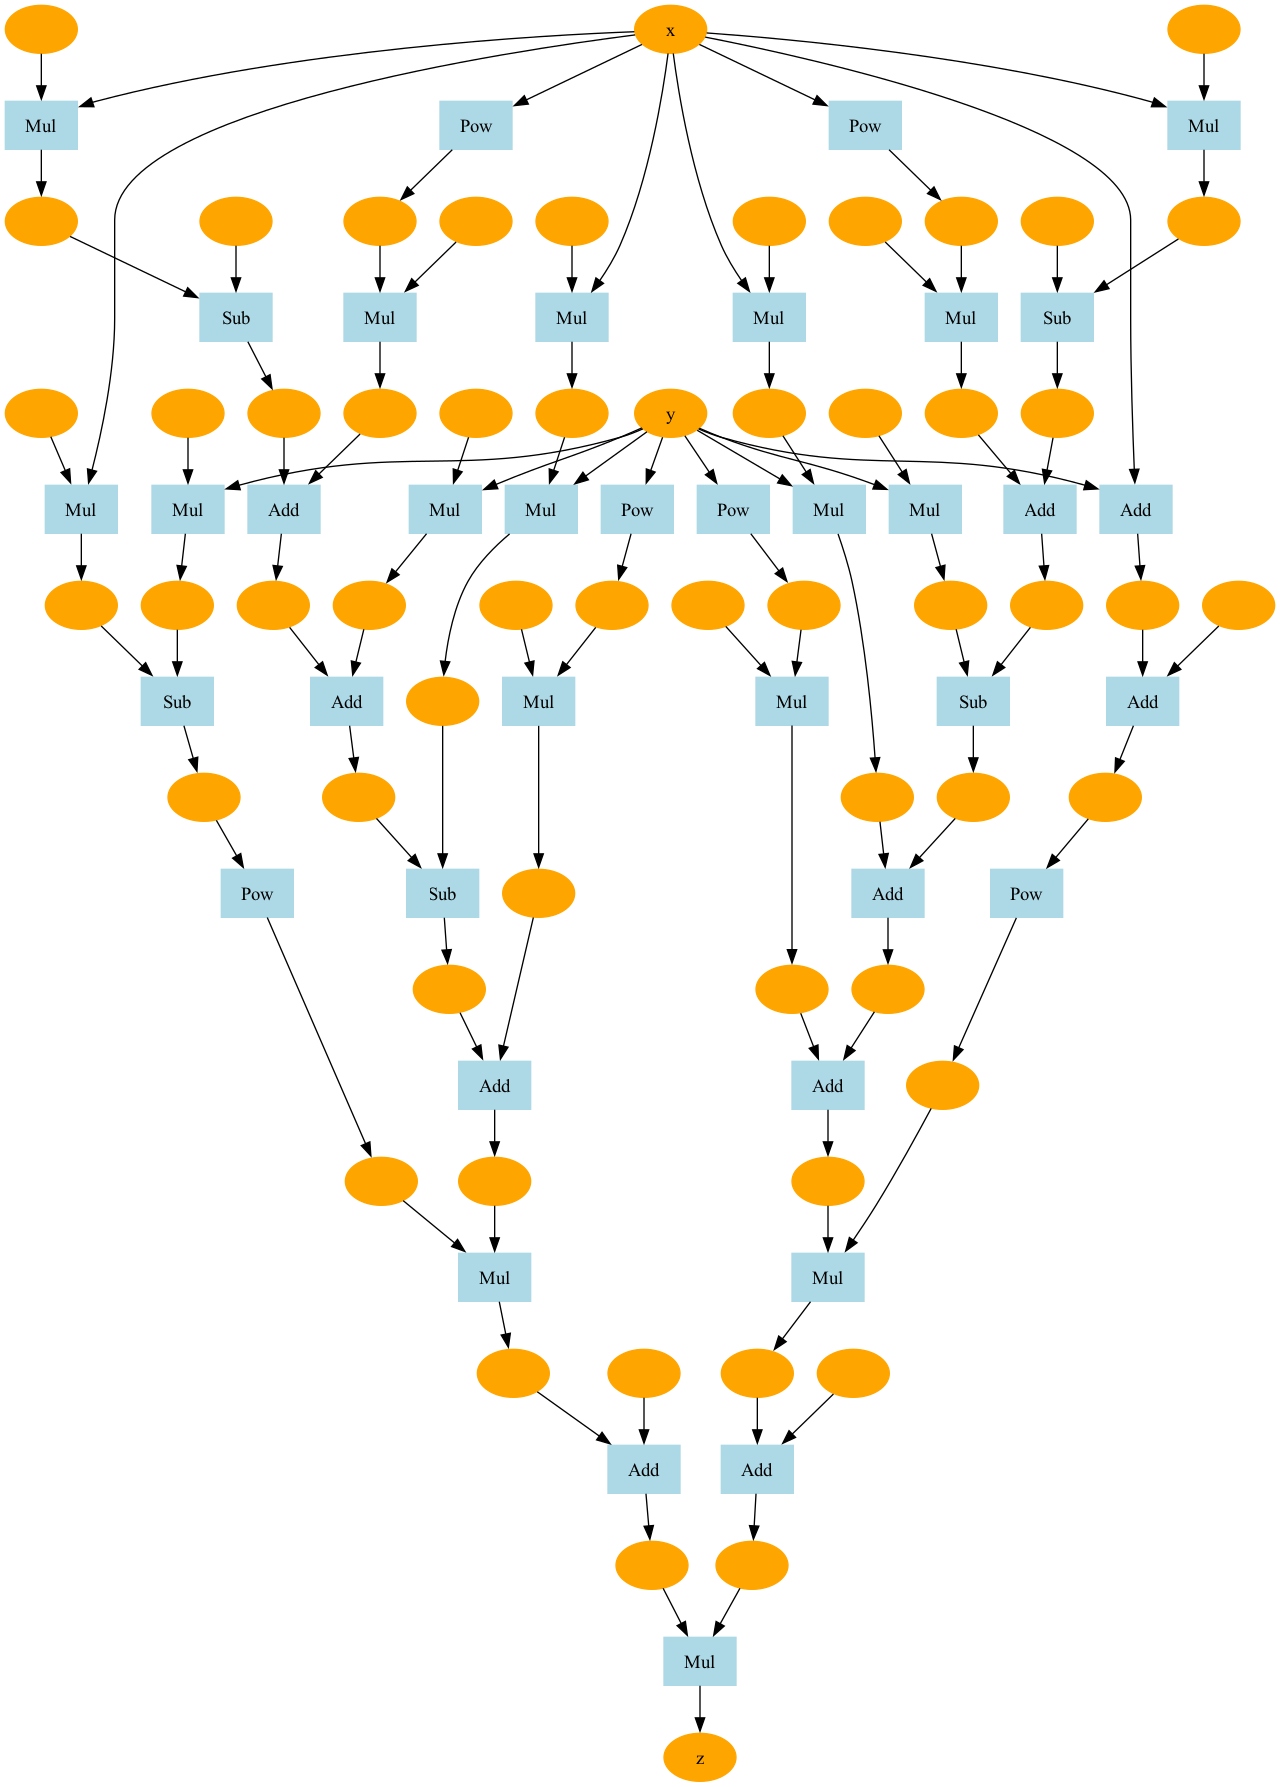

In [ ]:
# goldstein_price 함수의 계산 그래프

from dezero.utils import plot_dot_graph

x = Variable(np.array(3.0))
y = Variable(np.array(2.0))
z = goldstein_price(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='sample_4.png')

# 테일러 급수 미분
+ sin함수처럼 미분해도 값을 구하기 어려운 함수들을 해석학적으로 계산
+ 즉 테일러 급수로 변환하여 다항함수로 변환하면 만들어놓은 계산방식으로 미분값을 구할 수 있게됨

In [ ]:
# sin 함수 구현

from dezero import Function

class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx
    
def sin(x):
    return Sin()(x)

x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
0.7071067811865476


## sin함수 taylor 급수로 변환
sin(x) = $\frac{x}{1!} - \frac{x^3}{3!} + \frac{x^5}{5!} - \frac{x^7}{7!} + ... = \displaystyle\sum_{i=0}^{\infin}{(-1)^{i}\frac{x^{2i+1}}{(2i+1)!}}$

In [ ]:
# taylor sin 함수 구현
import math

# taylor 급수의 나머지를 threshold로 설정하여 계산을 중단, 나머지(threshold)가 1e-4보다 작아지면 계산을 중단
def taylor_sin(x, threshold=1e-4):
    y = 0
    for i in range(1000):
        # np.math가 곧 deprecated 될 예정이므로 math로 변경
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

x = Variable(np.array(np.pi / 4))
y = taylor_sin(x)
y.backward()

print(f"y.data: {y.data}, sin(x): {np.sin(np.pi / 4)}")
print(x.grad)

y.data: 0.7071064695751781, sin(x): 0.7071067811865475
0.7071032148228457


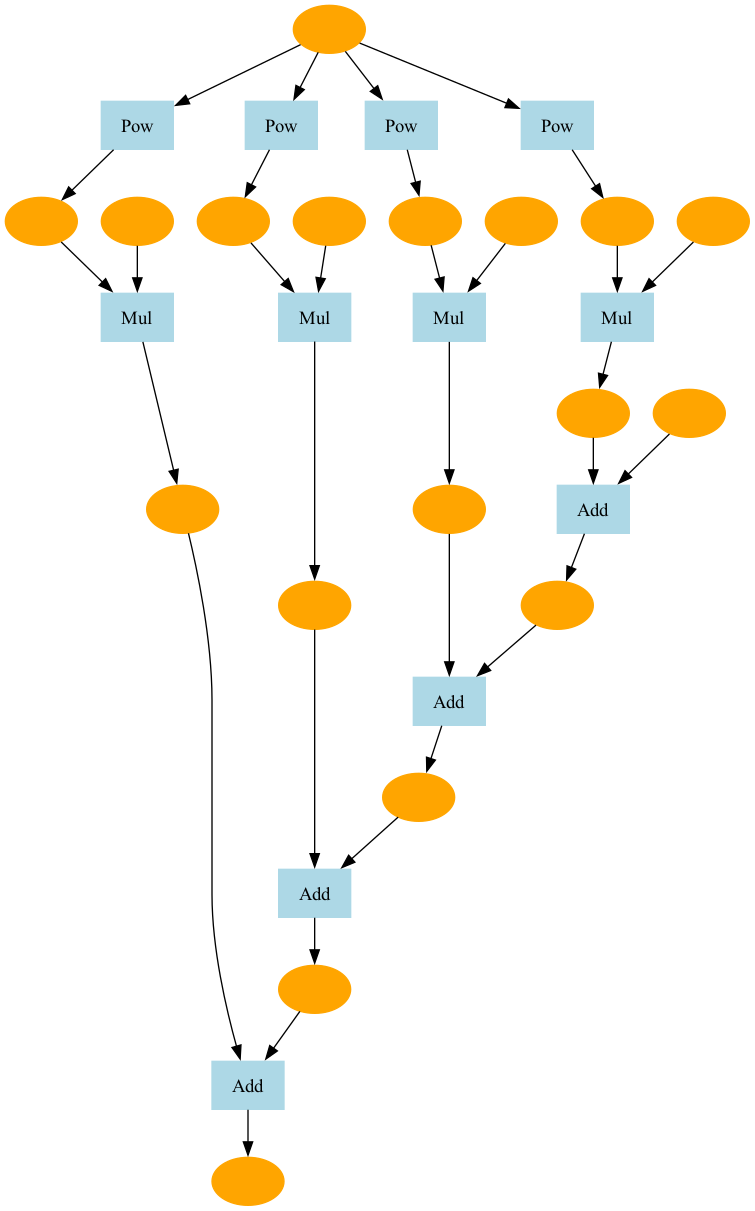

In [ ]:
plot_dot_graph(y, verbose=False, to_file='sample_5.png')

threshold -> sin함수를 근사하는데 테일러 급수의 오차값이 threshold보다 작을때까지 근사를 하는것 이므로

threshold값이 작아질수록 계산하는 반복수가 많아진다.

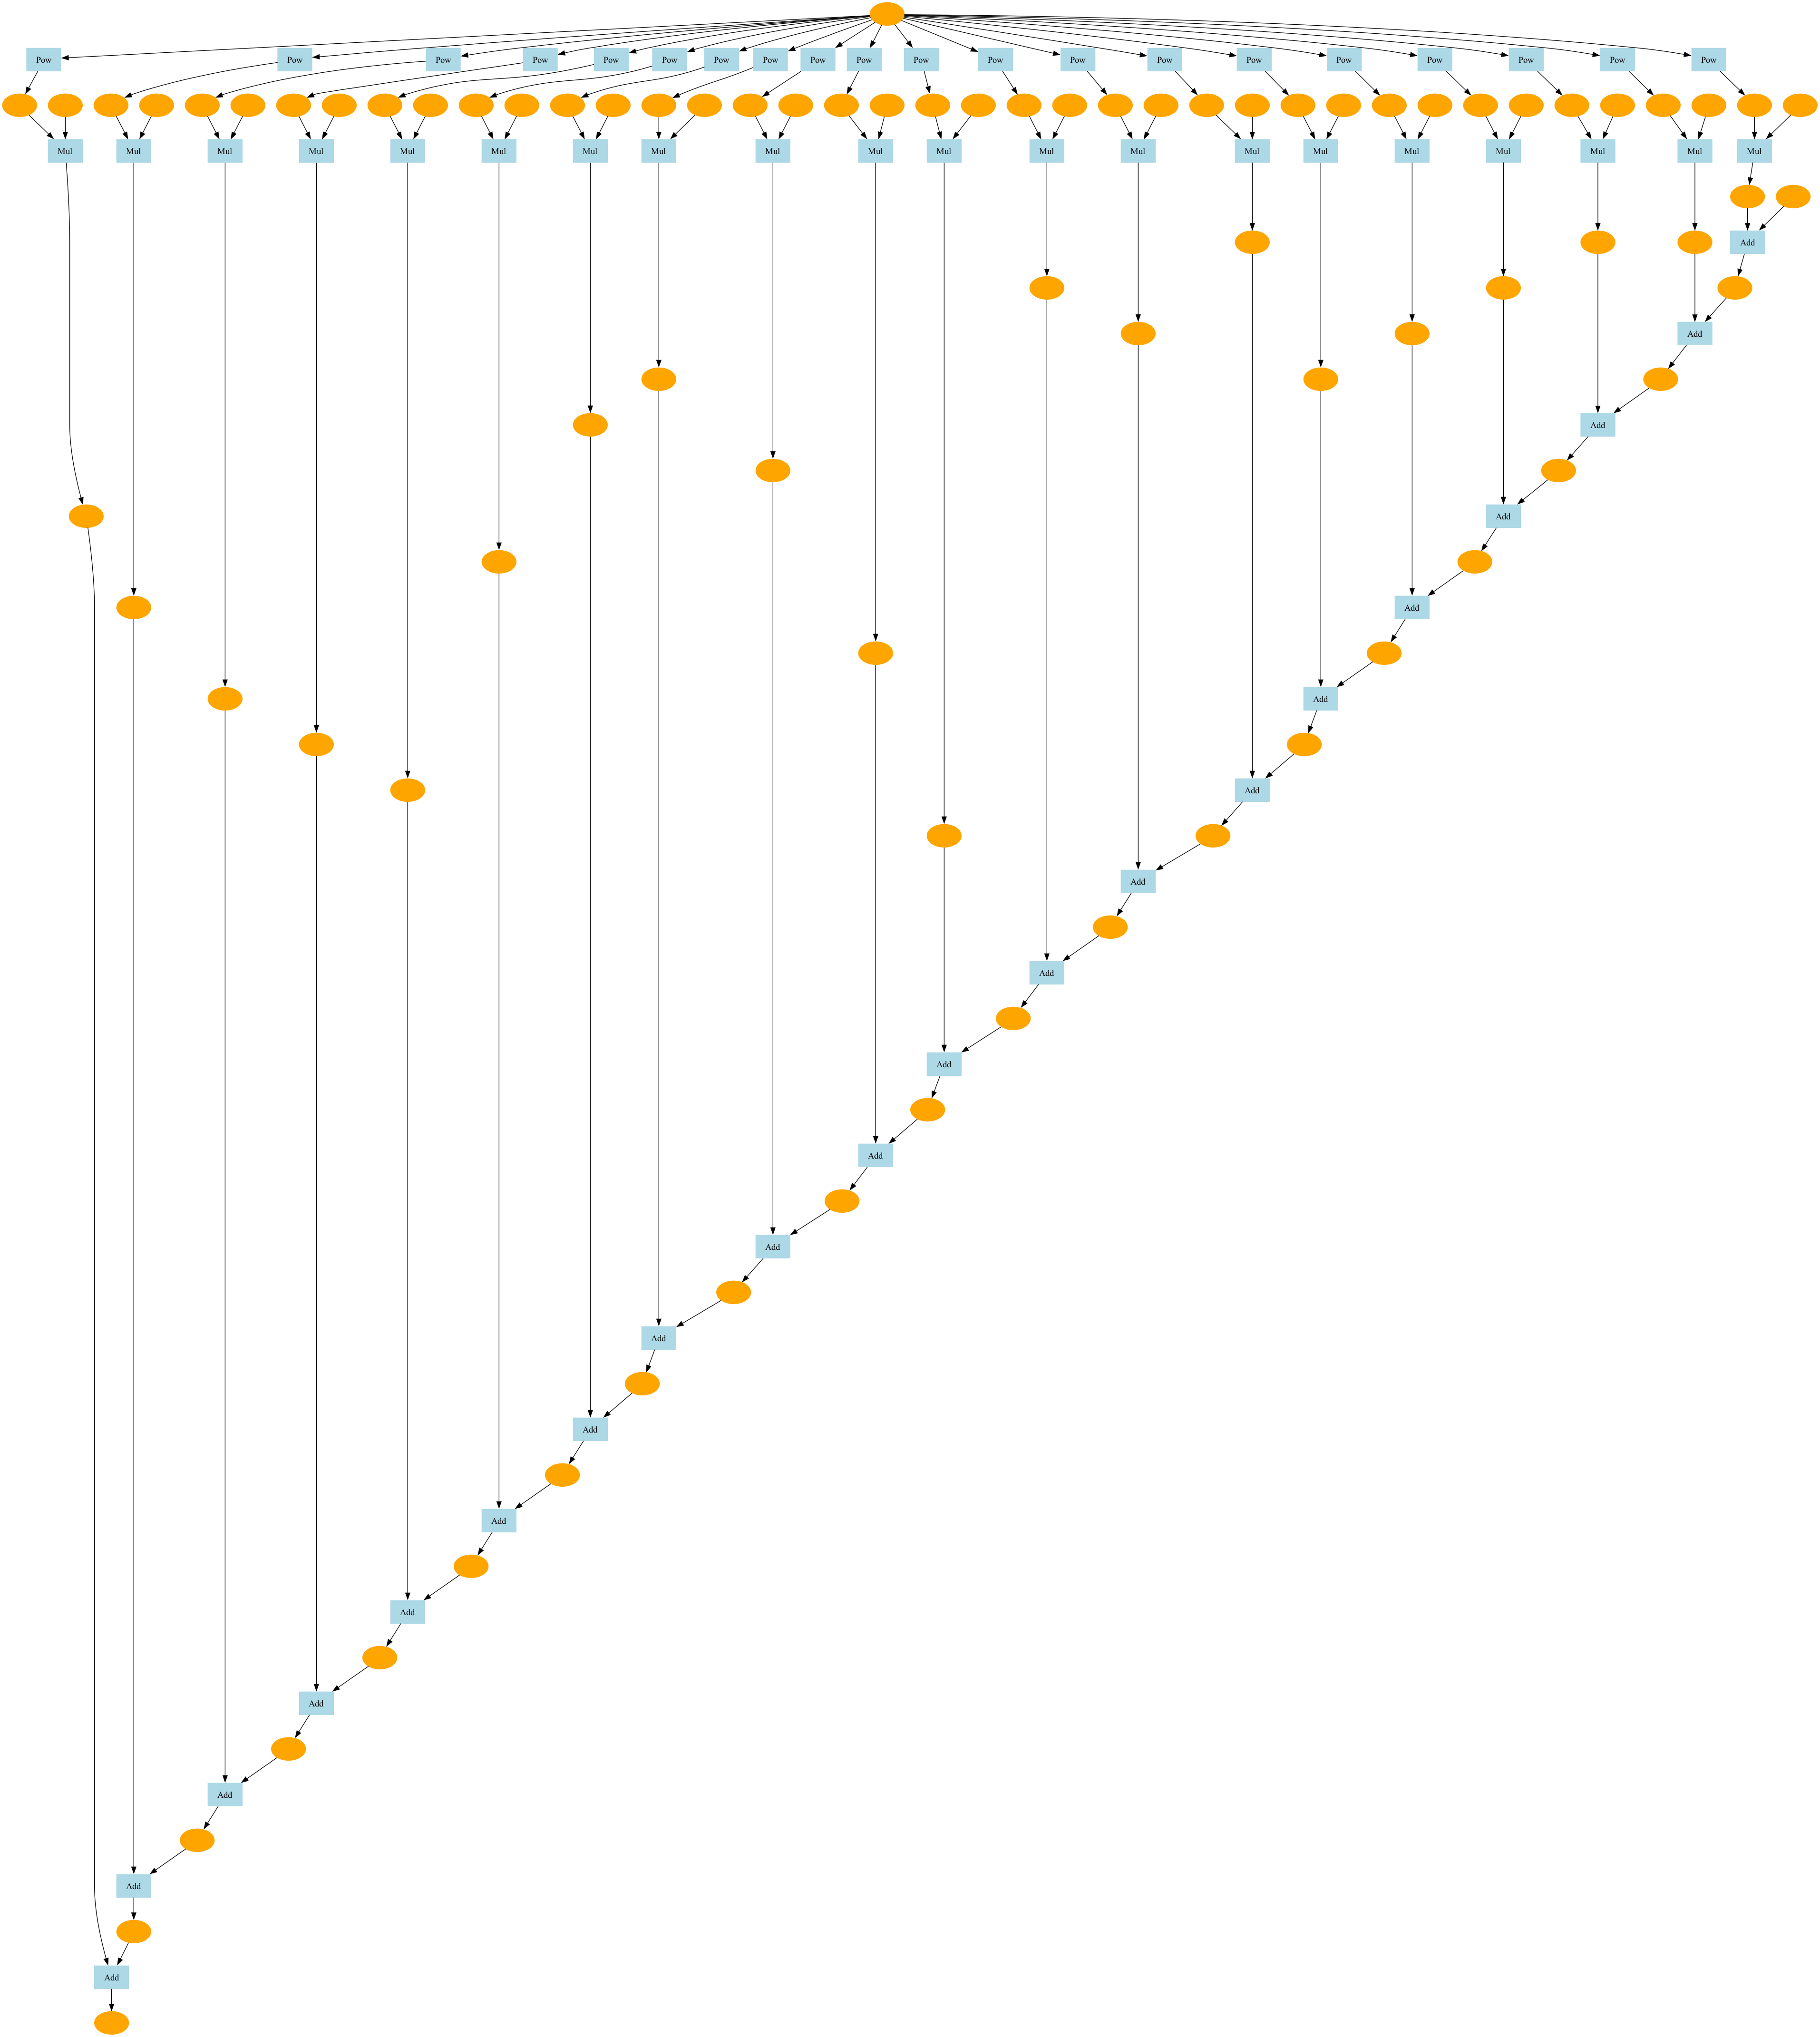

In [ ]:
def taylor_sin(x, threshold=1e-50):
    y = 0
    for i in range(1000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

x = Variable(np.array(np.pi / 4))
y = taylor_sin(x)
y.backward()

plot_dot_graph(y, verbose=False, to_file='sample_6.png')

# 함수 최적화
+ 함수의 최소값을 찾는 일
+ 즉 신경망 학습 목표가 된다.
+ 최적화하기 위해 내적이 최소가 되는 값으로 기울기를 갱신해야함.
+ 내적값이 최소 즉 원래벡터의 반대방향이 되어야한다.

In [ ]:
# 로젠브록 함수 구현

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
y = rosenbrock(x0, x1)
y.backward()

print(y.data)
print(x0.grad, x1.grad)

401.0
-2.0 400.0


In [ ]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(i, x0, x1)
    y = rosenbrock(x0, x1)
    
    # cleargrad를 안하면 기울기가 계속 누적되므로 cleargrad를 해줘야 함
    # x0, x1좌표에서 미분값의 learning_rate를 곱한 값을 빼면서 이동하고
    # 초기화 한뒤 이동한 x0, x1 좌표에서 다시 미분값을 계산하면서 해야하기때문
    x0.cleargrad()
    x1.cleargrad()
    y.backward()
    
    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

0 variable(0.0) variable(2.0)
1 variable(0.002) variable(1.6)
2 variable(0.0052759968) variable(1.2800008)
3 variable(0.009966698110960038) variable(1.0240062072284468)
4 variable(0.01602875299014943) variable(0.8192248327970044)
5 variable(0.02324750923068761) variable(0.6554312504220874)
6 variable(0.031290846214210376) variable(0.5244530896747561)
7 variable(0.039780241951514035) variable(0.41975829515116514)
8 variable(0.04835473570612382) variable(0.3361231296508763)
9 variable(0.05671405943493354) variable(0.26936613981374286)
10 variable(0.06463840226323121) variable(0.2161362087585121)
11 variable(0.07198937826156711) variable(0.17374459161623834)
12 variable(0.07869927242171229) variable(0.14003216740948807)
13 variable(0.08475507379959696) variable(0.11326444902353183)
14 variable(0.0901819257435144) variable(0.0920482437257805)
15 variable(0.09502862514911821) variable(0.07526515092678615)
16 variable(0.09935624532071949) variable(0.062018208660975245)
17 variable(0.10322996

최적값인 (1,1)에 도달하지 못한 모습

# 뉴턴 방법 최적화
+ 기존 경사하강법은 수렴 속도가 너무 느림
+ 테일러 급수로 함수 변환 (근사한 2차 방정식으로)
+ 특정 지점에서의 테일러 급수로 근사한 2차 방정식은 원래 식의 특정지점의 미분값이 비슷하기 때문
+ 따라서 1차 미분 + 2차 미분값 모두 사용
+ f(x)는 f(a) + f'(a)(x-a) + 1/2 f''(a)(x-a)^2로 근사된다.
+ 따라서 값이 0인곳, x = a - f'(a)/f''(a)
    + 경사하강법은 learning_rate * f'(x) 으로 갱신
    + 뉴턴 방법은 f'(x)/f''(x) 으로 갱신

In [ ]:
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

# 2차 미분값은 직접 계산해야함
def gx2(x):
    return 12 * x ** 2 - 4

x = Variable(np.array(-2.0))
iter = 10

for i in range(iter):
    print(i, x)
    y = f(x)
    x.cleargrad()
    y.backward()
    
    x.data -= x.grad / gx2(x.data)

0 variable(-2.0)
1 variable(-1.4545454545454546)
2 variable(-1.1510467893775467)
3 variable(-1.0253259289766978)
4 variable(-1.0009084519430513)
5 variable(-1.0000012353089454)
6 variable(-1.000000000002289)
7 variable(-1.0)
8 variable(-1.0)
9 variable(-1.0)


## 로젠브록 최적화 비교
위에선 로젠브록 최적화에 대해서 반복을 50000번 해야 (1,1)에 도달한다고 했는데

뉴턴 방법 예시로는 다른 함수가 나온다.

이에 로젠브록과 비교를 해야한다고 생각하는데

왜 인터넷 찾아봐도 다 똑같이

x ** 4 - 2 * x ** 2

이 함수에 대해서만 다루고 로젠브록을 테일러 급수 2차 근사까지 한 인터넷 글은 없을까?

이게 더 궁금하지 않는가?

다 똑같은 블로그나 인터넷글에

다 똑같이 저 함수에서 멈춘다.

따라서 로젠브록 테일러 급수 2차 근사값까지 계산하여 구해보았다.

이변수 함수 테일러 급수 2차 근사

테일러 급수 2차 근사

$[ f(x, y) \approx f(x_0, y_0) + f_x(x_0, y_0)(x - x_0) + f_y(x_0, y_0)(y - y_0) + \frac{1}{2}f_{xx}(x_0, y_0)(x - x_0)^2 + \frac{1}{2}f_{yy}(x_0, y_0)(y - y_0)^2 + f_{xy}(x_0, y_0)(x - x_0)(y - y_0) ]$

각각 미분 함수

$(f_x = \frac{\partial f}{\partial x} = -2(1 - x) - 400x(y - x^2))$

$(f_y = \frac{\partial f}{\partial y} = 200(y - x^2))$

$(f_{xx} = \frac{\partial^2 f}{\partial x^2} = 2 - 400(y - x^2) + 800x^2)$

$(f_{yy} = \frac{\partial^2 f}{\partial y^2} = 200)$

$(f_{xy} = \frac{\partial^2 f}{\partial x \partial y} = -400x)$

각각 미분값

$(f_x = -2)$

$(f_y = 400)$

$(f_{xx} = -798)$

$(f_{yy} = 200)$

$(f_{xy} = 0)$

최종 테일러 2차 근사 함수

$[ f(x, y) \approx -399 - 2x + 400y - 399x^2 + 100(y - 2)^2 ]$

In [5]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2
    return y

def rosenbrock_gx2(x0, x1):
    return -399 - 2 * x0 + 400 * x1 - 399 * x0 ** 2 + 100 * (x1 - 2) ** 2

iter = 100

for i in range(iter):
    print(i, x0, x1)
    y = rosenbrock(x0, x1)
    
    x0.cleargrad()
    x1.cleargrad()
    y.backward()
    
    x0.data -= x0.grad / rosenbrock_gx2(x0.data, x1.data)
    x1.data -= x1.grad / rosenbrock_gx2(x0.data, x1.data)

0 variable(0.0) variable(2.0)
1 variable(0.004987531172069825) variable(1.0024442600197858)
2 variable(0.0443083337711329) variable(-0.9900905146189425)
3 variable(-0.11534690424585665) variable(1.1217864102707837)
4 variable(-0.5170573312892053) variable(-9.334291847692516)
5 variable(-0.28601495016668044) variable(-9.113102595447481)
6 variable(-0.15856143236585668) variable(-8.89143573213971)
7 variable(-0.08665517022356287) variable(-8.665812123256933)
8 variable(-0.04632267954669272) variable(-8.434827423355616)
9 variable(-0.024056359003261026) variable(-8.197682199805334)
10 variable(-0.01201409796665104) variable(-7.953728660371704)
11 variable(-0.005653019932826253) variable(-7.702309390968129)
12 variable(-0.0023787771047901946) variable(-7.442689803304665)
13 variable(-0.0007387115292833821) variable(-7.174018109155331)
14 variable(6.190344309068229e-05) variable(-6.895288442763323)
15 variable(0.00044654003204013074) variable(-6.605296245765973)
16 variable(0.00063427984476

### 6번만에 도달한다고 쓰여져 있는데 왜 안되는건지 모르겠음

밑에 코드는 gpt에게 물어본 답변

위에 오류는

1. 로젠브룩 함수의 1차 미분, 2차 미분 행렬값이 필요함
2. 행렬 곱으로 계산을 해야함

In [ ]:
import numpy as np

# 로젠브룩 함수 정의
def rosenbrock(x):
    return 100.0 * (x[1] - x[0]**2) ** 2 + (1 - x[0])**2

# 로젠브룩 함수의 그라디언트 정의
def rosenbrock_gradient(x):
    grad = np.zeros(2)
    grad[0] = -400 * x[0] * (x[1] - x[0]**2) + 2 * (x[0] - 1)
    grad[1] = 200 * (x[1] - x[0]**2)
    return grad

# 로젠브룩 함수의 헤시안 정의
def rosenbrock_hessian(x):
    hessian = np.zeros((2, 2))
    hessian[0, 0] = 1200 * x[0]**2 - 400 * x[1] + 2
    hessian[0, 1] = -400 * x[0]
    hessian[1, 0] = -400 * x[0]
    hessian[1, 1] = 200
    return hessian

# 초기 값 설정
x = np.array([0.0, 2.0])

# 반복 횟수 설정
iterations = 10

# 뉴턴 방법을 사용하여 최적화
for i in range(iterations):
    grad = rosenbrock_gradient(x)
    hessian = rosenbrock_hessian(x)
    x -= np.linalg.inv(hessian).dot(grad)
    print(f"Iteration {i+1}, x: {x}")

Iteration 1, x: [-0.00250627  0.        ]
Iteration 2, x: [ 0.99874216 -0.00501251]
Iteration 3, x: [0.9987484  0.99749837]
Iteration 4, x: [1.         0.99999843]
Iteration 5, x: [1. 1.]
Iteration 6, x: [1. 1.]
Iteration 7, x: [1. 1.]
Iteration 8, x: [1. 1.]
Iteration 9, x: [1. 1.]
Iteration 10, x: [1. 1.]


*해당 코드를 현재 사용하고 있는 dezero 패키지에 맞게 변형 할 예정*

---

# 고차미분
+ 역전파시 계산그래프가 만들어지지 않으므로 1차 미분에 대한 값만 나오지 2차 이상의 미분값을 얻을 수 없었음
+ 역전파를 계산할 때 계산 결과값을 input.data -> numpy 값으로 받기 때문에 연속해서 미분을 하려면 variable을 사용해야한다.
+ 역전파시에도 계산 그래프를 만들어야 함
+ 모든 변수를 variable로 계산하게 한다 -> 계산 그래프 이용시 variable 인스턴스여야 하기 때문 -> 그래야 계속해서 함수를 사용하면서 연속적인 미분이 가능함

```python
class Variable:
    ...
    def backward(self, retain_grad=False):
        if self.grad is None:
            # numpy에서 variable 인스턴스를 참조하게 함
            # 이렇게 해야 미분값을 저장할때 numpy로 저장하고 끝나는게 아닌 variable 인스턴스를 담게된다.
            self.grad = Variable(np.ones_like(self.data))

class Mul(Function):
    ...
    def backward(self, gy):
        # variable 인스턴스로 만들어 variable에서 데이터를 꺼내 쓰는 방식이 아닌
        # 역전파시에도 variable 인스턴스가 전달되게 변경함
        x0, x1 = self.inputs
```

In [1]:
# mul 수정후 구현

from dezero import Variable
import numpy as np

x0 = Variable(np.array(2.0))
x1 = Variable(np.array(3.0))
y = x0 * x1
y.backward()

# 결과값이 np.array -> variable로 변경
print(x0.grad, x1.grad)

variable(3.0) variable(2.0)


```python
    # create_graph를 인수로 받기
    def backward(self, retain_grad=False, create_graph=False):
        ...
        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]

            # create_graph 인수를 사용하여 필요할 때만 계산 그래프 그리도록 함
            with using_config('enable_backprop', create_graph):
                ...
                for x, gx in zip(f.inputs, gxs):
                    if x.grad is None:
                        x.grad = gx
                    else:
                        # 연속해서 해야하기 때문에 미분값을 더함
                        x.grad = x.grad + gx

                    if x.creator is not None:
                        add_func(x.creator)
                    ...
```

In [2]:
# 2차 미분 구현

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

# 1차 미분
x = Variable(np.array(2.0))
y = f(x)
y.backward(create_graph=True)
print(x.grad)

# 2차 미분
# 1차 미분값을 다시 입력값으로 하여 2차 미분값을 구함
gx = x.grad
# cleargrad를 해주지 않으면 기울기가 계속 누적되므로 cleargrad를 해줘야 함
x.cleargrad()
gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


In [3]:
x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)
    
    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)
    
    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad
    
    x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### 수동으로 구했던 로젠브록 함수를 다시 적용해보기

In [38]:
def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
iters = 10000

for i in range(iters):
    print(i, x0, x1)
    
    y = rosenbrock(x0, x1)
    x0.cleargrad()
    x1.cleargrad()
    y.backward(create_graph=True)
    
    gx0 = x0.grad
    gx1 = x1.grad
    x0.cleargrad()
    x1.cleargrad()
    gx0.backward()
    gx1.backward()
    
    gx0_2 = x0.grad
    gx1_2 = x1.grad
    
    x0.data -= gx0.data / gx0_2.data
    x1.data -= gx1.data / gx1_2.data

0 variable(0.0) variable(2.0)
1 variable(-0.002506265664160401) variable(0.0)
2 variable(0.6636032299269801) variable(6.250039062744142e-06)
3 variable(0.22504460945592203) variable(-1.3458198590389854)
4 variable(-0.017883764611776626) variable(1.1936192341914622)
5 variable(-0.00399113295097551) variable(0.041527310582589516)
6 variable(-0.15340691476810872) variable(0.00034466000965267807)
7 variable(-0.11262909494584905) variable(0.01808936163807574)
8 variable(-0.07662147723075335) variable(0.013678822982355895)
9 variable(-0.02069444235737221) variable(0.00690837432786671)
10 variable(0.22689698437967093) variable(0.0006858051431004137)
11 variable(0.3393197249293068) variable(0.09368447866947775)
12 variable(0.38746274057379876) variable(0.16044250807658444)
13 variable(0.3111638036480708) variable(0.11461265227496023)
14 variable(0.2422522751234801) variable(0.06750902511581433)
15 variable(0.19620746226893823) variable(0.05039372309415957)
16 variable(0.14582951761981952) vari

gpt 답변

(x_0, x_1)에 대한 헤시안 행렬을 직접 계산하거나 근사하여 사용합니다.

헤시안 행렬의 역행렬을 효율적으로 계산하거나 근사하는 방법을 적용합니다.

헤시안 행렬 -> 이계도 함수

이계도 함수의 행렬식을 구하여 처음 알려준 것처럼 각각 행렬식으로 구해야 하는것같다.

# 삼각함수 구현
+ backward에서도 계산그래프를 유지하기 위해
+ forward에는 np의 삼각함수, backward에는 fuction의 cos함수를 호출하게 해야함 -> 그래야 연속적으로 함수를 사용하면서 역전파를 연속해서 실행할 수 있기 때문

```python
class Sin(Function):
    def forward(self, x):
        # 여긴 numpy 사용
        y = np.sin(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        # 여긴 dezero function함수의 cos 사용
        gx = gy * cos(x)
        return gx

class Cos(Function):
    def forward(self, x):
        # 여긴 numpy 사용
        y = np.cos(x)
        return y

    def backward(self, gy):
        x, = self.inputs
        # 여긴 dezero function함수의 sin 사용
        gx = gy * -sin(x)
        return gx
```

In [14]:
# sin 함수 구현

import dezero.functions as F

x = Variable(np.array(np.pi / 3))
y = F.sin(x)
# 1차 미분
y.backward(create_graph=True)

for i in range(5):
    gx = x.grad
    x.cleargrad()
    
    # 2차 미분 : -sin(x) = -sin(pi/3) = -sqrt(3)/2 = -0.86602540378
    gx.backward(create_graph=True)
    print(x.grad)

variable(-0.8660254037844386)
variable(-0.5000000000000001)
variable(0.8660254037844386)
variable(0.5000000000000001)
variable(-0.8660254037844386)


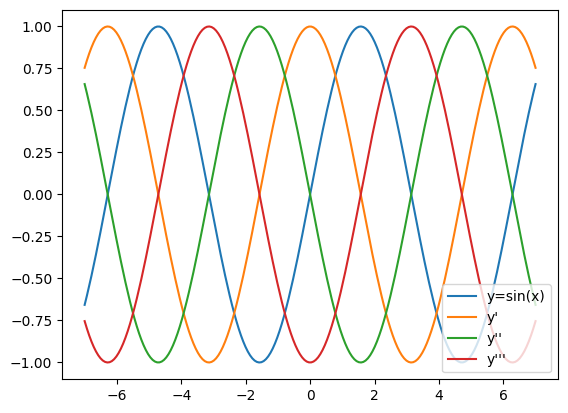

In [17]:
# sin 함수 고차 미분 시각화

import matplotlib.pyplot as plt

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

# 하이퍼볼릭 탄젠트 함수 구현
+ tanh(x)
+ $y' = 1-y^{2}$ -> 일부로 딱 깔끔하게 나오는 함수를 만들었을까?, 마치 1권에 softmax loss 역전파값 처럼?
+ 삼각함수와 마찬가지로 forward에선 numpy 패키지를 사용하고 backward에서는 필요한 값 가져오기

```python
class Tanh(Function):
    def forward(self, x):
        y = xp.tanh(x)
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * (1 - y * y)
        return gx
```

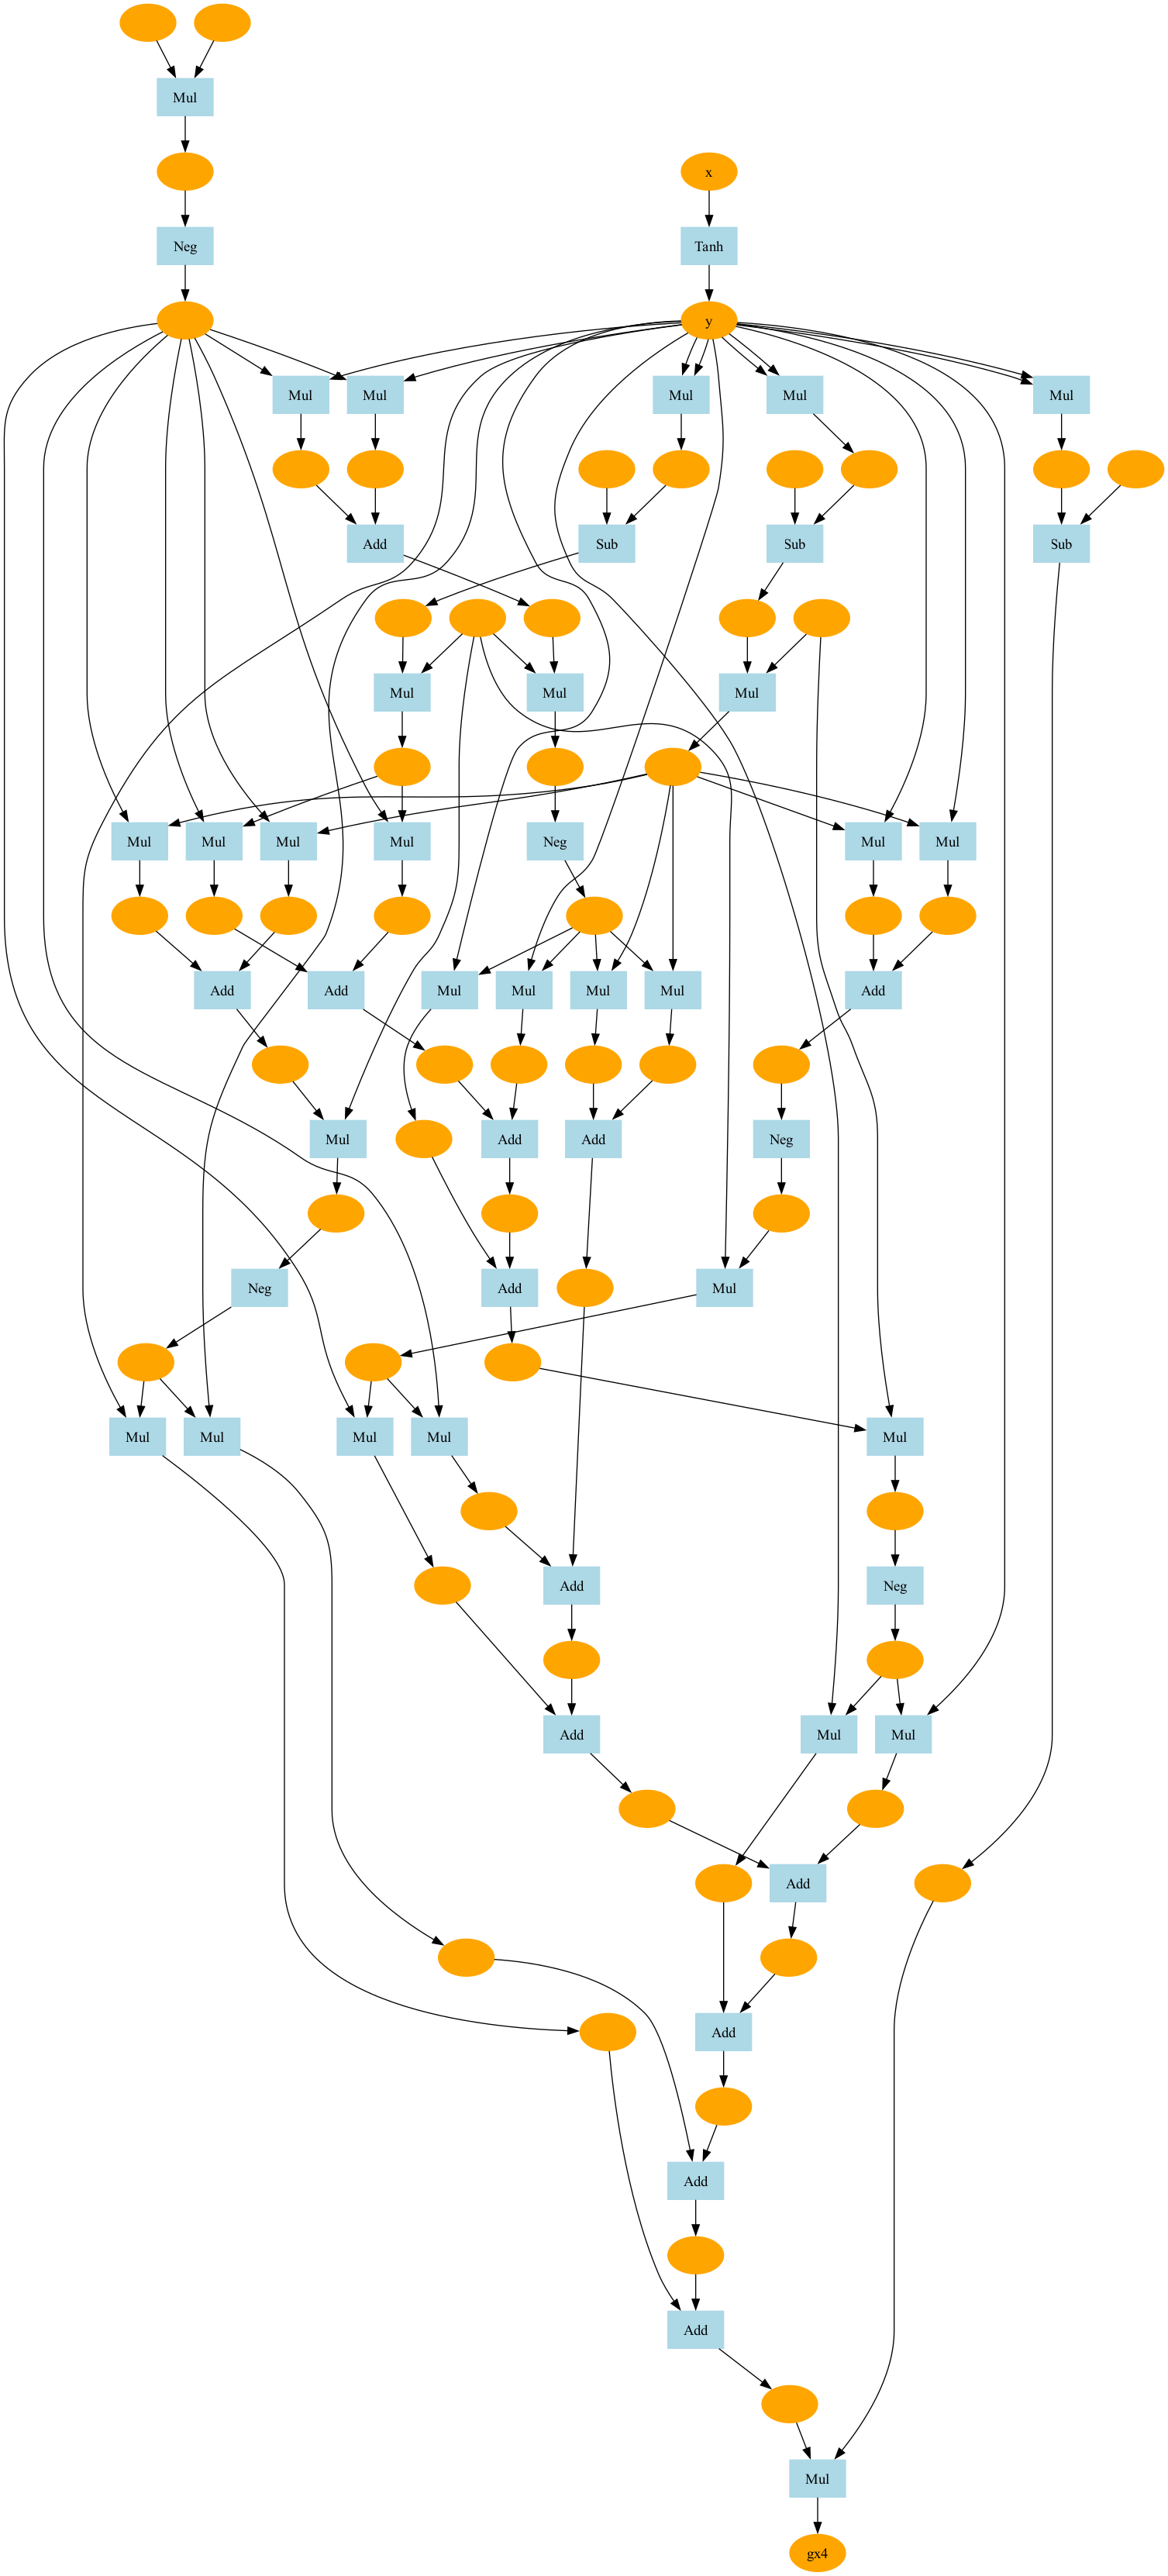

In [36]:
from dezero.utils import plot_dot_graph

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 3

for i in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)
    
gx = x.grad
gx.name = 'gx' + str(iters + 1)

plot_dot_graph(gx, verbose=False, to_file='sample_7.png')

이후 n계도 함수의 미분값을 계산할 수 있음

---

+ 로젠블록 함수 및 다른 함수들의 수동, 자동 고차 미분에 대한 값을 시간 나면 구해보기
+ 아마 다변수 함수로 가면서 계산하는 방식이 다른듯 함 -> 이계도함수를 행렬로 이용해서 계산하기?